<a href="https://colab.research.google.com/github/btian/deep-learning/blob/main/debiasing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

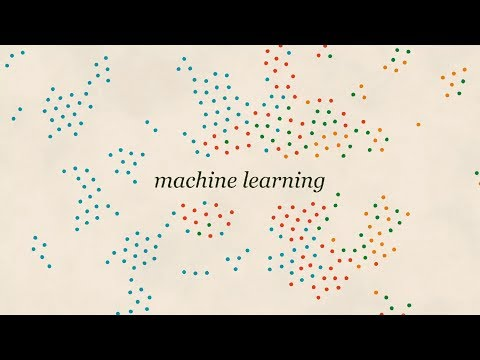

In [1]:
import IPython
IPython.display.YouTubeVideo('59bMh59JQDo')

In [2]:
%tensorflow_version 2.x
import tensorflow as tf

import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

!pip install mitdeeplearning -qq
import mitdeeplearning as mdl

     |████████████████████████████████| 2.1MB 16.3MB/s 


In [3]:
train_path = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1')
loader = mdl.lab2.TrainingDatasetLoader(train_path)

1263894528/1263889489 [==============================] - 12s 0us/step
Opening /root/.keras/datasets/train_face.h5
Loading data into memory...


In [4]:
n = loader.get_train_size()
print(n)
(images, labels) = loader.get_batch(100)

109914


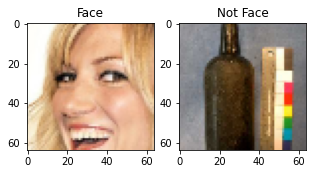

In [5]:
face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

idx_face = 23
idx_not_face = 6

plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title('Face'); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title('Not Face'); plt.grid(False)

In [6]:
n_filters = 12

def make_standard_classifier(n_outputs=1):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNorm = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  model = tf.keras.Sequential([
    Conv2D(filters=1*n_filters, kernel_size=5, strides=2),
    BatchNorm(),
    Conv2D(filters=2*n_filters, kernel_size=5, strides=2),
    BatchNorm(),
    Conv2D(filters=4*n_filters, kernel_size=3, strides=2),
    BatchNorm(),
    Conv2D(filters=6*n_filters, kernel_size=3, strides=2),
    BatchNorm(),
    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
  ])
  return model


standard_classifier = make_standard_classifier()

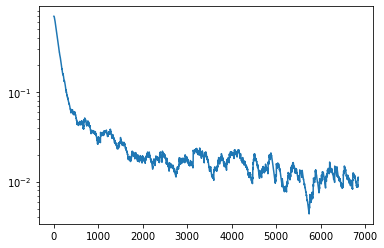

100%|██████████| 3434/3434 [00:32<00:00, 104.37it/s]


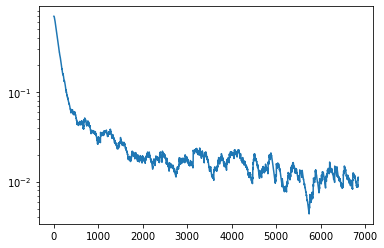

In [7]:
bs = 32
epochs = 2
lr = 1e-3

optimizer = tf.keras.optimizers.Adam(lr)
loss_history = mdl.util.LossHistory(smoothing_factor=0.99)
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear()


@tf.function
def standard_train_step(x, y):
  with tf.GradientTape() as tape:
    logits = standard_classifier(x)
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
  grads = tape.gradient(loss, standard_classifier.trainable_variables)
  optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables))
  return loss


for epoch in range(epochs):
  for idx in tqdm(range(loader.get_train_size() // bs)):
    x, y = loader.get_batch(bs)
    loss = standard_train_step(x, y)

    loss_history.append(loss.numpy().mean())
    plotter.plot(loss_history.get())

In [8]:
batch_x, batch_y = loader.get_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))

print(f'Standard CNN accuracy on training set: {acc_standard.numpy():.4f}')

Standard CNN accuracy on training set: 0.9968


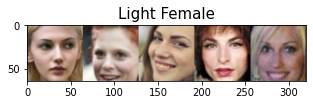

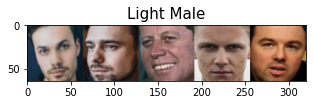

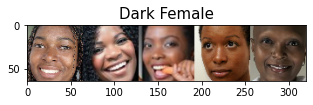

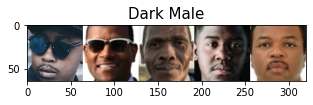

In [9]:
test_faces = mdl.lab2.get_test_faces()
keys = ['Light Female', 'Light Male', 'Dark Female', 'Dark Male']
for group, key in zip(test_faces, keys):
  plt.figure(figsize=(5,5))
  plt.imshow(np.hstack(group))
  plt.title(key, fontsize=15)

Text(0.5, 1.0, 'Standard Classifier Predictions')

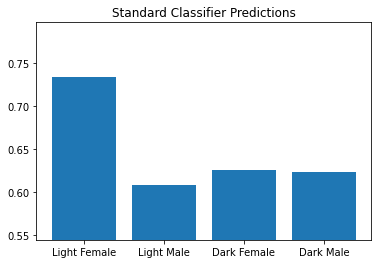

In [10]:
standard_classifier_logits = [standard_classifier(np.array(x, dtype=np.float32)) for x in test_faces]
standard_classifier_probs = tf.squeeze(tf.sigmoid(standard_classifier_logits))

xx = range(len(keys))
yy = standard_classifier_probs.numpy().mean(1)
plt.bar(xx, yy)
plt.xticks(xx, keys)
plt.ylim(max(0, yy.min() - yy.ptp() / 2.), yy.max() + yy.ptp() / 2.)
plt.title('Standard Classifier Predictions')

In [12]:
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=5e-4):
  latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
  reconstruction_loss = tf.reduce_mean(tf.abs(x - x_recon), axis=(1,2,3))
  vae_loss = kl_weight * latent_loss + reconstruction_loss
  return vae_loss

In [13]:
### VAE Reparameterization ###
def sampling(z_mean, z_logsigma):
  batch, latent_dim = z_mean.shape
  epsilon = tf.random.normal(shape=(batch, latent_dim))
  z = z_mean + tf.exp(0.5 * z_logsigma) * epsilon
  return z

In [14]:
### Loss function for DB-VAE ###
"""Loss function for DB-VAE.
# Arguments
    x: true input x
    x_pred: reconstructed x
    y: true label (face or not face)
    y_logit: predicted labels
    mu: mean of latent distribution (Q(z|X))
    logsigma: log of standard deviation of latent distribution (Q(z|X))
# Returns
    total_loss: DB-VAE total loss
    classification_loss = DB-VAE classification loss
"""
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):
  vae_loss = vae_loss_function(x, x_pred, mu, logsigma)
  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(y, y_logit)
  # Use the training data labels to create variable face_indicator:
  #   indicator that reflects which training data are images of faces
  face_indicator = tf.cast(tf.equal(y, 1), tf.float32)
  total_loss = tf.reduce_mean(classification_loss + face_indicator * vae_loss)
  return total_loss, classification_loss

In [40]:
n_filters = 12
latent_dim = 100

def make_face_decoder_network():
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  BatchNorm = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape

  decoder = tf.keras.Sequential([
    Dense(units=4*4*6*n_filters),
    Reshape(target_shape=(4, 4, 6*n_filters)),
    BatchNorm(),
    # Upscaling convolutions
    #Conv2DTranspose(filters=6*n_filters, kernel_size=3, strides=2),
    #BatchNorm(),
    Conv2DTranspose(filters=4*n_filters, kernel_size=3, strides=2),
    BatchNorm(),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3, strides=2),
    BatchNorm(),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5, strides=2),
    Conv2DTranspose(filters=3, kernel_size=5, strides=2),
  ])
  return decoder

In [41]:
class DB_VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super().__init__(self)
    self.latent_dim = latent_dim

    num_encoder_dims = 2*self.latent_dim + 1

    self.encoder = make_standard_classifier(num_encoder_dims)
    self.decoder = make_face_decoder_network()

  def encode(self, x):
    encoder_output = self.encoder(x)
    y_logit = tf.expand_dims(encoder_output[:, 0], -1)
    z_mean = encoder_output[:, 1:self.latent_dim+1]
    z_logsigma = encoder_output[:, self.latent_dim+1:]
    return y_logit, z_mean, z_logsigma

  def reparameterize(self, z_mean, z_logsigma):
    z = sampling(z_mean, z_logsigma)
    return z

  def decode(self, z):
    reconstruction = self.decoder(z)
    return reconstruction

  def call(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    z = self.reparameterize(z_mean, z_logsigma)
    recon = self.decode(z)
    return y_logit, z_mean, z_logsigma, recon

  def predict(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    return y_logit

dbvae = DB_VAE(latent_dim)

In [42]:
def get_latent_mu(images, dbvae, batch_size=1024):
  N = images.shape[0]
  mu = np.zeros((N, latent_dim))
  for start_ind in range(0, N, batch_size):
    end_ind = min(start_ind+batch_size, N+1)
    batch = (images[start_ind:end_ind]).astype(np.float32)/255.
    _, batch_mu, _ = dbvae.encode(batch)
    mu[start_ind:end_ind] = batch_mu
  return mu

In [43]:
### Resampling algorithm for DB-VAE ###
def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=1e-3):
  print('Recomputing the sampling probabilities')
  mu = get_latent_mu(images, dbvae)
  training_sample_p = np.zeros(mu.shape[0])
  for i in range(latent_dim):
    latent_distribution = mu[:,i]
    hist_density, bin_edges = np.histogram(latent_distribution, density=True, bins=bins)

    bin_edges[0] = -float('inf')
    bin_edges[-1] = float('inf')

    bin_idx = np.digitize(latent_distribution, bin_edges)

    hist_smoothed_density = hist_density + smoothing_fac
    hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)

    p = 1.0 / hist_smoothed_density[bin_idx-1]
    p = p / np.sum(p)
    training_sample_p = np.maximum(p, training_sample_p)
  training_sample_p /= np.sum(training_sample_p)
  return training_sample_p


Starting epoch 6/6
Recomputing the sampling probabilities


  0%|          | 0/3434 [00:00<?, ?it/s]

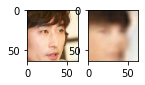

 14%|█▍        | 493/3434 [00:04<00:24, 117.84it/s]

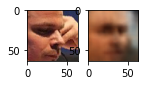

 29%|██▉       | 991/3434 [00:09<00:21, 112.56it/s]

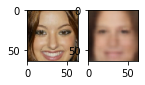

 44%|████▎     | 1499/3434 [00:13<00:17, 110.34it/s]

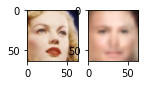

 58%|█████▊    | 1997/3434 [00:18<00:12, 117.44it/s]

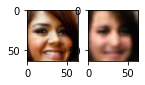

 73%|███████▎  | 2492/3434 [00:23<00:08, 116.68it/s]

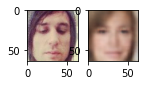

 87%|████████▋ | 2996/3434 [00:27<00:03, 115.51it/s]

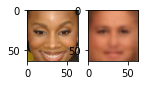

100%|██████████| 3434/3434 [00:31<00:00, 108.33it/s]


In [44]:
### Training DB-VAE ###

batch_size = 32
learning_rate = 5e-4
latent_dim = 100

num_epochs = 6

dbvae = DB_VAE(latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def debiasing_train_step(x, y):
  with tf.GradientTape() as tape:
    y_logit, z_mean, z_logsigma, x_recon = dbvae(x)
    loss, class_loss = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)
  grads = tape.gradient(loss, dbvae.trainable_variables)
  optimizer.apply_gradients(zip(grads, dbvae.trainable_variables))
  return loss

all_faces = loader.get_all_train_faces()

if hasattr(tqdm, '_instances'): tqdm._instances.clear()

for i in range(num_epochs):
  IPython.display.clear_output(wait=True)
  print('Starting epoch {}/{}'.format(i+1, num_epochs))

  p_faces = get_training_sample_probabilities(all_faces, dbvae)

  for j in tqdm(range(loader.get_train_size() // batch_size)):
    (x, y) = loader.get_batch(batch_size, p_pos=p_faces)
    loss = debiasing_train_step(x, y)

    # Plot progress every 500 steps
    if j % 500 == 0:
      mdl.util.plot_sample(x, y, dbvae)

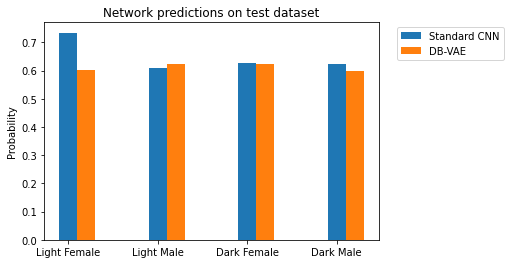

In [45]:
dbvae_logits = [dbvae.predict(np.array(x, dtype=np.float32)) for x in test_faces]
dbvae_probs = tf.squeeze(tf.sigmoid(dbvae_logits))

xx = np.arange(len(keys))
plt.bar(xx, standard_classifier_probs.numpy().mean(1), width=0.2, label='Standard CNN')
plt.bar(xx+0.2, dbvae_probs.numpy().mean(1), width=0.2, label='DB-VAE')
plt.xticks(xx, keys)
plt.title('Network predictions on test dataset')
plt.ylabel('Probability'); plt.legend(bbox_to_anchor=(1.04,1), loc='upper left');

In [46]:
dbvae.summary()

Model: "db_vae_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_21 (Sequential)   (None, 201)               743801    
_________________________________________________________________
sequential_22 (Sequential)   (32, 64, 64, 3)           166587    
Total params: 910,388
Trainable params: 909,788
Non-trainable params: 600
_________________________________________________________________


In [47]:
dbvae.encoder.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 32, 32, 12)        912       
_________________________________________________________________
batch_normalization_55 (Batc (None, 32, 32, 12)        48        
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 16, 16, 24)        7224      
_________________________________________________________________
batch_normalization_56 (Batc (None, 16, 16, 24)        96        
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 8, 8, 48)          10416     
_________________________________________________________________
batch_normalization_57 (Batc (None, 8, 8, 48)          192       
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 4, 4, 72)        

In [48]:
dbvae.decoder.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (32, 1152)                116352    
_________________________________________________________________
reshape_10 (Reshape)         (32, 4, 4, 72)            0         
_________________________________________________________________
batch_normalization_59 (Batc (32, 4, 4, 72)            288       
_________________________________________________________________
conv2d_transpose_42 (Conv2DT (32, 8, 8, 48)            31152     
_________________________________________________________________
batch_normalization_60 (Batc (32, 8, 8, 48)            192       
_________________________________________________________________
conv2d_transpose_43 (Conv2DT (32, 16, 16, 24)          10392     
_________________________________________________________________
batch_normalization_61 (Batc (32, 16, 16, 24)        